In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from naive_bayes import NaiveBayesClassifier

In [2]:
x_train_scaled = pd.read_csv('cleaned/x_train.csv', header = None)
x_test_scaled = pd.read_csv('cleaned/x_test.csv', header = None)

y_train = pd.read_csv('cleaned/y_train.csv', header = None).values.ravel()
y_test = pd.read_csv('cleaned/y_test.csv', header = None).values.ravel()

In [3]:
def scores_df(model):
    try:
        train_pred = model.predict(x_train_scaled)
        test_pred = model.predict(x_test_scaled)
    except:
        train_pred = model.predict('train')
        test_pred = model.predict()

    df =  pd.DataFrame({'Train': ['{:.1%}'.format(accuracy_score(y_train, train_pred)),
                                  '{:.1%}'.format(precision_score(y_train, train_pred)),
                                  '{:.1%}'.format(recall_score(y_train, train_pred)),
                                  '{:.1%}'.format(f1_score(y_train, train_pred))],
                        'Test': ['{:.1%}'.format(accuracy_score(y_test, test_pred)),
                                 '{:.1%}'.format(precision_score(y_test, test_pred)),
                                 '{:.1%}'.format(recall_score(y_test, test_pred)),
                                 '{:.1%}'.format(f1_score(y_test, test_pred))]},
                        index = ['Accuracy', 'Precision', 'Recall', 'F1'])
    
    df.index.name = 'Score'

    return df

## K-Nearest Neighbors (KNN)

In [4]:
ks = np.arange(1, 21)

knn_cv_scores = []
knn_test_scores = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k, n_jobs = -1)
    knn_cv_scores.append(cross_val_score(knn, x_train_scaled, y_train, cv = 10, scoring = 'accuracy'))

    knn.fit(x_train_scaled, y_train)
    knn_test_scores.append(accuracy_score(y_test, knn.predict(x_test_scaled)))

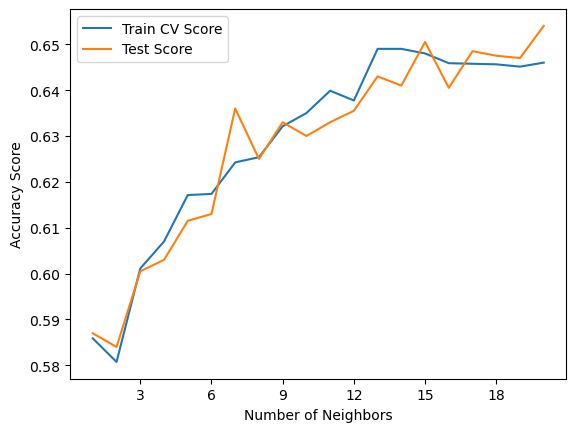

In [5]:
plt.plot(ks, np.array(knn_cv_scores).mean(axis = 1), label = 'Train CV Score')
plt.plot(ks, knn_test_scores, label = 'Test Score')

plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy Score')

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.legend()

plt.show()

In [6]:
best_k = ks[np.array(knn_cv_scores).mean(axis = 1).argmax()]

knn = KNeighborsClassifier(n_neighbors = best_k, n_jobs = -1).fit(x_train_scaled, y_train)

print(f'Optimal number of neighbors: {best_k}')

scores_df(knn)

Optimal number of neighbors: 13


,Train,Test
Score,,
Accuracy,71.2%,64.3%
Precision,71.4%,66.3%
Recall,70.0%,62.4%
F1,70.7%,64.3%


## Bag-of-words Naive Bayes Classifier w/ Add-α Smoothing

In [7]:
alphas = np.logspace(-1, 1, 10)

nbc_train_scores = []
nbc_test_scores = []

nbc = NaiveBayesClassifier('tweets/tweets_10k.csv')
nbc.pretrain()

for alpha in alphas:
    
    nbc.train(alpha)

    nbc_train_scores.append(accuracy_score(y_train, nbc.predict('train')))
    nbc_test_scores.append(accuracy_score(y_test, nbc.predict()))

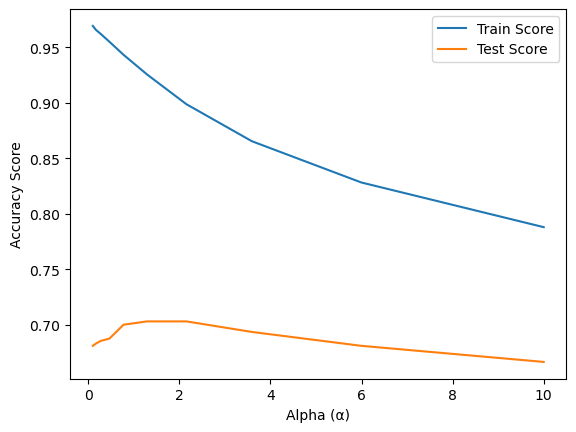

In [8]:
plt.plot(alphas, nbc_train_scores, label = 'Train Score')
plt.plot(alphas, nbc_test_scores, label = 'Test Score')

plt.xlabel('Alpha (α)')
plt.ylabel('Accuracy Score')

plt.legend()

plt.show()

In [9]:
best_alpha = alphas[np.mean([np.array(nbc_train_scores), np.array(nbc_test_scores)], axis = 0).argmax()]

nbc.train(best_alpha)

print(f'Optimal alpha value: {best_alpha}')

scores_df(nbc)

Optimal alpha value: 0.09999999999999999


,Train,Test
Score,,
Accuracy,96.9%,68.1%
Precision,98.0%,72.2%
Recall,95.7%,61.8%
F1,96.9%,66.6%


## Linear Support Vector Machine (SVM)

In [10]:
Cs = np.logspace(-1, 1, 10)

svm_cv_scores = []
svm_test_scores = []

for C in Cs:
    svm = LinearSVC(C = C, random_state = 1, dual = True, max_iter = 1000000)
    svm_cv_scores.append(cross_val_score(svm, x_train_scaled, y_train, cv = 10, scoring = 'accuracy'))

    svm.fit(x_train_scaled, y_train)
    svm_test_scores.append(accuracy_score(y_test, svm.predict(x_test_scaled)))

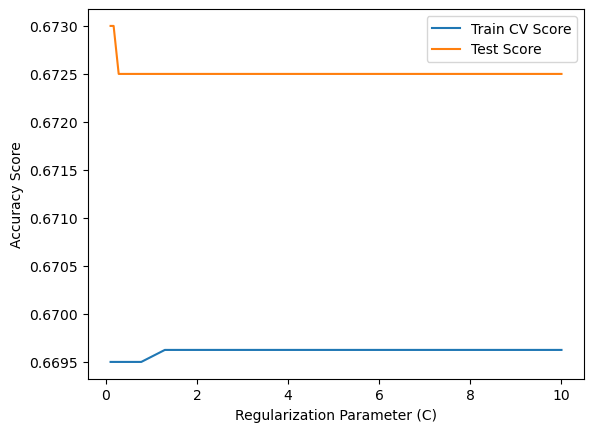

In [11]:
plt.plot(Cs, np.array(svm_cv_scores).mean(axis = 1), label = 'Train CV Score')
plt.plot(Cs, svm_test_scores, label = 'Test Score')

plt.xlabel('Regularization Parameter (C)')
plt.ylabel('Accuracy Score')

plt.legend()

plt.show()

In [12]:
best_c = Cs[np.array(svm_cv_scores).mean(axis = 1).argmax()]

svm = LinearSVC(C = best_c, dual = True, random_state = 1, max_iter = 1000000).fit(x_train_scaled, y_train)

print(f'Optimal C-value: {best_c}')

scores_df(svm)

Optimal C-value: 1.2915496650148839


,Train,Test
Score,,
Accuracy,67.3%,67.2%
Precision,66.2%,67.9%
Recall,69.3%,69.1%
F1,67.8%,68.5%


## Random Forest Classifier

In [13]:
ns = np.linspace(100, 1000, 10)

rfc_cv_scores = []
rfc_test_scores = []

for n in ns:
    rfc = RandomForestClassifier(n_estimators = int(n), random_state = 1, n_jobs = -1)
    rfc_cv_scores.append(cross_val_score(rfc, x_train_scaled, y_train, cv = 5, scoring = 'accuracy'))

    rfc.fit(x_train_scaled, y_train)
    rfc_test_scores.append(accuracy_score(y_test, rfc.predict(x_test_scaled)))

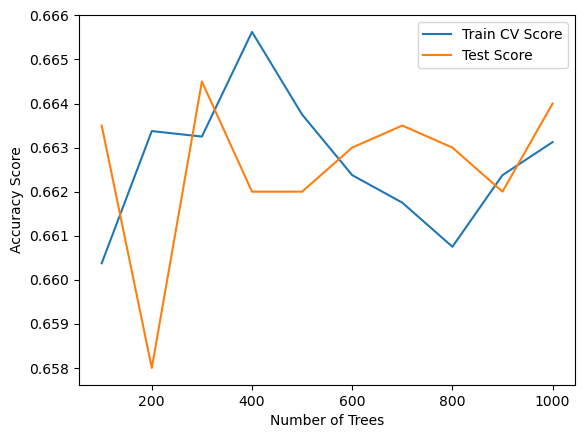

In [14]:
plt.plot(ns, np.array(rfc_cv_scores).mean(axis = 1), label = 'Train CV Score')
plt.plot(ns, rfc_test_scores, label = 'Test Score')

plt.xlabel('Number of Trees')
plt.ylabel('Accuracy Score')

plt.legend()

plt.show()

In [15]:
best_n = int(ns[np.array(rfc_cv_scores).mean(axis = 1).argmax()])

rfc = RandomForestClassifier(n_estimators = best_n, random_state = 1, n_jobs = -1).fit(x_train_scaled, y_train)

print(f'Optimal number of trees: {best_n}')

scores_df(rfc)

Optimal number of trees: 400


,Train,Test
Score,,
Accuracy,99.2%,66.2%
Precision,98.4%,68.1%
Recall,99.9%,64.6%
F1,99.2%,66.3%


## Logistic Regression w/ ElasticNet Regularization

In [16]:
Cs = np.logspace(-2, -1, 100)
l1_ratios = np.arange(0.01, 1.01, 0.01)

lreg = LogisticRegressionCV(Cs = Cs, l1_ratios = l1_ratios, scoring = 'accuracy', penalty = 'elasticnet', solver = 'saga', random_state = 1, n_jobs = -1).fit(x_train_scaled, y_train)

In [17]:
print(f'Optimal C-value: {lreg.C_}')
print(f'Optimal L1 ratio: {lreg.l1_ratio_}')

scores_df(lreg)

Optimal C-value: [0.05994843]
Optimal L1 ratio: [0.72]


,Train,Test
Score,,
Accuracy,67.4%,67.2%
Precision,66.4%,67.8%
Recall,69.1%,68.9%
F1,67.7%,68.4%


## Merged Results

In [18]:
scores_merged = pd.concat([scores_df(knn), scores_df(nbc), scores_df(svm), scores_df(rfc), scores_df(lreg)], axis = 1)

scores_merged.columns = pd.MultiIndex.from_product([['KNN', 'Naive Bayes', 'Linear SVM', 'Random Forest', 'Logistic Regression'], set(scores_merged.columns)])

scores_merged

KNN        Naive Bayes        Linear SVM        Random Forest  \
           Train   Test       Train   Test      Train   Test         Train   
Score                                                                        
Accuracy   71.2%  64.3%       96.9%  68.1%      67.3%  67.2%         99.2%   
Precision  71.4%  66.3%       98.0%  72.2%      66.2%  67.9%         98.4%   
Recall     70.0%  62.4%       95.7%  61.8%      69.3%  69.1%         99.9%   
F1         70.7%  64.3%       96.9%  66.6%      67.8%  68.5%         99.2%   

                 Logistic Regression         
            Test               Train   Test  
Score                                        
Accuracy   66.2%               67.4%  67.2%  
Precision  68.1%               66.4%  67.8%  
Recall     64.6%               69.1%  68.9%  
F1         66.3%               67.7%  68.4%